In [16]:
import pickle

def load_and_preview_features(file_path, dataset_name, print_limit=5):
    """
    加载并预览特征数据，只打印正负中性标签的前若干条。
    返回所有数据（未截断）。
    """
    with open(file_path, 'rb') as file:
        features = pickle.load(file)

    print(f"\n--- {dataset_name.upper()} DATASET ---")

    count = 0
    for i, item in enumerate(features):
        label = item.get('label', 'N/A')
        if label not in ['Positive', 'Negative', 'Neutral']:
            continue

        if count < print_limit:
            video_id = item.get('video_id', 'N/A')
            clip_id = item.get('clip_id', 'N/A')
            label_1 = item.get('label_1', 'N/A')
            mode = item.get('mode', 'N/A')
            text = item.get('text', 'N/A')
            text_feature_shape = item['text_feature'].shape if 'text_feature' in item else 'N/A'
            audio_feature_shape = item['audio_feature'].shape if 'audio_feature' in item else 'N/A'
            #vision_feature_shape = item['vision_features'].shape if 'vision_features' in item else 'N/A'
            #vision_feature_shape1 = item['vision_feature_resnet'].shape if 'vision_feature_resnet' in item else 'N/A'

            print(f"Item {i}:")
            print(f"  video_id: {video_id}")
            print(f"  clip_id: {clip_id}")
            print(f"  label_1: {label_1}")
            print(f"  label: {label}")
            print(f"  mode: {mode}")
            print(f"  text: {text}")
            print(f"  text_feature_shape: {text_feature_shape}")
            print(f"  audio_feature_shape: {audio_feature_shape}")
            #print(f"  vision_feature_shape (DenseNet): {vision_feature_shape}")
            #print(f"  vision_feature_shape (ResNet): {vision_feature_shape1}")
            print("-" * 50)
            count += 1

    print(f"共加载样本数: {len(features)}（其中三类标签样本展示前 {print_limit} 条）")
    return features

In [17]:
train_features = load_and_preview_features('train_features.pkl', 'train')
valid_features = load_and_preview_features('valid_features.pkl', 'valid')
test_features = load_and_preview_features('test_features.pkl', 'test')

KeyboardInterrupt: 

In [3]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 假设 features 已经加载并包含在内
train_data = [item for item in train_features if item['mode'] == 'train']
valid_data = [item for item in valid_features if item['mode'] == 'valid']
test_data = [item for item in test_features if item['mode'] == 'test']

In [4]:
del train_features, valid_features,test_features

In [5]:
# 定义离散化函数
def discretize_label(score):
    if -3 <= score < -2.5:
        return -3
    elif -2.5 <= score < -1.5:
        return -2
    elif -1.5 <= score < -0.5:
        return -1
    elif -0.5 <= score < 0.5:
        return 0
    elif 0.5 <= score < 1.5:
        return 1
    elif 1.5 <= score < 2.5:
        return 2
    elif 2.5 <= score <= 3:
        return 3
    else:
        return None

# 将 label_1 离散化并保存为标签
train_y = np.array([discretize_label(item['label_1']) for item in train_data])
valid_y = np.array([discretize_label(item['label_1']) for item in valid_data])
test_y = np.array([discretize_label(item['label_1']) for item in test_data])



# 打印示例以验证离散化后的标签
print("Sample converted labels (train):", train_y[:500])
print("Sample converted labels (valid):", valid_y[:500])
print("Sample converted labels (test):", test_y[:500])

Sample converted labels (train): [ 1  1  0  0  1  1  0  1  0 -1  0  0  0 -1 -2  1  0  0 -2  0  0  0  0  2
  0  2  2  2  1  3  1  2  3  0  2  1  2 -1  0  1  2  2  2  2  2  0  0 -1
  0  0  0  0  1  0  0 -1 -2  0  2  1  1  1  2  2  1  1  1  0  2  0  0  0
  1  1  0  1  1  0  0  1  1  0  0  0  2  2  1  1  0  1  0  1  1  0 -1  0
 -1  1  0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1 -1 -1  0  0  0
  0  0  0  0  0  1  1  1  1  1  0  1  0  0 -1  0  1  0  0  1  0  0  1  0
  0  1  0  0  1  0  0  0  0  0  0  0  1  1  1  0 -1  0  0  1  0  0  0  1
  1  1  1  0  0  1  1  2 -1  0 -1  0  0  0  2  1  1  0  1  0  0  0  0  1
  0  0  0  0  0  0  0  1  0  0  0 -1  0  1  0  0  0  0  0  0  0  0  0  1
  1  1  1  0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  0  1  2  1  1  1
  0  0  0  0 -1  0  0  2  0  2  0  2  2  2  0  1  0  0 -1 -2  0  0  1  1
  0  0  0  0  1  0 -1  0 -1  0 -1  0  0  0  2  0  0  1  0  1  0  0  0 -1
  2  1  1  2 -1  1  0 -2 -1  0  0  0  0  0  0  1  1  2  2  0  0  0  0  0
  1  2  1  1  2  0

In [6]:
train_X_text = [item['text_feature'] for item in train_data]
valid_X_text = [item['text_feature'] for item in valid_data]
test_X_text = [item['text_feature'] for item in test_data]

train_X_audio = [item['audio_feature'] for item in train_data]
valid_X_audio = [item['audio_feature'] for item in valid_data]
test_X_audio = [item['audio_feature'] for item in test_data]

train_X_vision = [item['vision_feature_resnet'] for item in train_data]
valid_X_vision = [item['vision_feature_resnet'] for item in valid_data]
test_X_vision = [item['vision_feature_resnet'] for item in test_data]

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
# 初始化标签编码器
label_encoder = LabelEncoder()

# 对训练标签进行拟合并转换
train_Y = label_encoder.fit_transform(train_y)

# 使用相同的编码器来转换验证标签
valid_Y = label_encoder.transform(valid_y)

test_Y = label_encoder.transform(test_y)

In [8]:
import torch

# 将所有特征数据放入一个字典中
text_features = {
    'train_audio': train_X_audio,
    'valid_audio': valid_X_audio,
    'test_audio': test_X_audio
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in text_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        tensor_feature = tensor_feature.squeeze(0)  # 去掉大小为1的维度（假设是第一个维度）
        text_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

/tmp/ipykernel_1764/2523887850.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_feature = torch.tensor(feature)  # 将特征转换为tensor


Feature in train_audio at index 0 has shape: torch.Size([1284, 1024])
Feature in train_audio at index 1 has shape: torch.Size([438, 1024])
Feature in train_audio at index 2 has shape: torch.Size([963, 1024])
Feature in train_audio at index 3 has shape: torch.Size([711, 1024])
Feature in train_audio at index 4 has shape: torch.Size([821, 1024])
Feature in train_audio at index 5 has shape: torch.Size([811, 1024])
Feature in train_audio at index 6 has shape: torch.Size([464, 1024])
Feature in train_audio at index 7 has shape: torch.Size([591, 1024])
Feature in train_audio at index 8 has shape: torch.Size([546, 1024])
Feature in train_audio at index 9 has shape: torch.Size([573, 1024])
Feature in train_audio at index 10 has shape: torch.Size([121, 1024])
Feature in train_audio at index 11 has shape: torch.Size([366, 1024])
Feature in train_audio at index 12 has shape: torch.Size([407, 1024])
Feature in train_audio at index 13 has shape: torch.Size([573, 1024])
Feature in train_audio at ind

In [9]:
import torch

# 将所有特征数据放入一个字典中
text_features = {
    'train_text': train_X_text,
    'valid_text': valid_X_text,
    'test_text': test_X_text
}

# 遍历字典，转换为tensor并去掉维度，然后打印形状
for key, features in text_features.items():
    for i, feature in enumerate(features):
        tensor_feature = torch.tensor(feature)  # 将特征转换为tensor
        tensor_feature = tensor_feature.squeeze(0)  # 去掉大小为1的维度（假设是第一个维度）
        text_features[key][i] = tensor_feature  # 更新字典中的值
        print(f"Feature in {key} at index {i} has shape: {tensor_feature.shape}")

Feature in train_text at index 0 has shape: torch.Size([50, 768])
Feature in train_text at index 1 has shape: torch.Size([19, 768])
Feature in train_text at index 2 has shape: torch.Size([40, 768])
Feature in train_text at index 3 has shape: torch.Size([19, 768])
Feature in train_text at index 4 has shape: torch.Size([41, 768])
Feature in train_text at index 5 has shape: torch.Size([30, 768])
Feature in train_text at index 6 has shape: torch.Size([43, 768])
Feature in train_text at index 7 has shape: torch.Size([22, 768])
Feature in train_text at index 8 has shape: torch.Size([22, 768])
Feature in train_text at index 9 has shape: torch.Size([32, 768])
Feature in train_text at index 10 has shape: torch.Size([7, 768])
Feature in train_text at index 11 has shape: torch.Size([20, 768])
Feature in train_text at index 12 has shape: torch.Size([14, 768])
Feature in train_text at index 13 has shape: torch.Size([12, 768])
Feature in train_text at index 14 has shape: torch.Size([22, 768])
Featur

Feature in train_text at index 1121 has shape: torch.Size([11, 768])
Feature in train_text at index 1122 has shape: torch.Size([24, 768])
Feature in train_text at index 1123 has shape: torch.Size([20, 768])
Feature in train_text at index 1124 has shape: torch.Size([40, 768])
Feature in train_text at index 1125 has shape: torch.Size([39, 768])
Feature in train_text at index 1126 has shape: torch.Size([29, 768])
Feature in train_text at index 1127 has shape: torch.Size([17, 768])
Feature in train_text at index 1128 has shape: torch.Size([14, 768])
Feature in train_text at index 1129 has shape: torch.Size([10, 768])
Feature in train_text at index 1130 has shape: torch.Size([15, 768])
Feature in train_text at index 1131 has shape: torch.Size([10, 768])
Feature in train_text at index 1132 has shape: torch.Size([39, 768])
Feature in train_text at index 1133 has shape: torch.Size([8, 768])
Feature in train_text at index 1134 has shape: torch.Size([28, 768])
Feature in train_text at index 1135

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

class ThreeModal_Dataset(Dataset):
    def __init__(self, text_features, audio_features, labels):
        self.text_features = text_features
        self.audio_features = audio_features
        #self.vision_features = vision_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_features = self.text_features[idx]
        audio_features = self.audio_features[idx]
        #vision_features = self.vision_features[idx]
        labels = self.labels[idx]
        return text_features, audio_features, labels
    

def collate_fn(batch):
    # 从批次中分离音频特征、文本特征和标签
    text_features, audio_features, labels = zip(*batch)
    
    # 将音频特征和文本特征按照批次中最长的序列进行填充
    text_features_padded = pad_sequence(text_features, batch_first=True)    
    audio_features_padded = pad_sequence(audio_features, batch_first=True)
    #vision_features_padded = pad_sequence(vision_features, batch_first=True)    
    
    
    # 转换标签为张量
    labels = torch.tensor(labels)

    return text_features_padded, audio_features_padded, labels

In [11]:
train_Y_tensor = torch.tensor(train_Y)
valid_Y_tensor = torch.tensor(valid_Y)
test_Y_tensor = torch.tensor(test_Y)

# 创建Dataset实例
train_dataset = ThreeModal_Dataset(train_X_text, train_X_audio, train_Y_tensor)
valid_dataset = ThreeModal_Dataset(valid_X_text, valid_X_audio, valid_Y_tensor)
test_dataset = ThreeModal_Dataset(test_X_text, test_X_audio, test_Y_tensor)

# 创建DataLoader，使用自定义的collate_fn
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [12]:
del train_X_text, train_X_audio, train_X_vision, valid_X_text, valid_X_audio, valid_X_vision, valid_Y_tensor, test_X_text, test_X_audio, test_X_vision, test_Y_tensor

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextAudioCrossAttentionClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, num_heads, dropout_rate=0.1, num_classes=7):
        super(TextAudioCrossAttentionClassifier, self).__init__()

        self.dropout = nn.Dropout(dropout_rate)
        self.text_to_hidden = nn.Linear(text_dim, hidden_dim)
        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)

        self.cross_attention_text_audio = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.cross_attention_audio_text = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)

        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, text_features, audio_features):
        text_hidden = self.text_to_hidden(text_features).permute(1, 0, 2)
        audio_hidden = self.audio_to_hidden(audio_features).permute(1, 0, 2)

        text_audio_output, _ = self.cross_attention_text_audio(query=text_hidden, key=audio_hidden, value=audio_hidden)
        audio_text_output, _ = self.cross_attention_audio_text(query=text_hidden, key=text_hidden, value=text_hidden)

        text_audio_output = self.dropout(text_audio_output.permute(1, 0, 2))
        audio_text_output = self.dropout(audio_text_output.permute(1, 0, 2))

        # L2 归一化
        text_audio_norm = F.normalize(text_audio_output.mean(dim=1), p=2, dim=-1)
        audio_text_norm = F.normalize(audio_text_output.mean(dim=1), p=2, dim=-1)

        # 计算相似度矩阵
        similarity_matrix = torch.matmul(text_audio_norm, audio_text_norm.T)
        positive_samples = torch.diag(similarity_matrix)

        # 对比学习损失（安全版本）
        eps = 1e-8
        temperature = 0.07  # 稍微大一点，更稳定
        similarity_matrix = similarity_matrix / temperature
        positive_samples = positive_samples / temperature
        denominator = torch.exp(similarity_matrix).sum(dim=1) + eps

        contrastive_loss = -torch.log(torch.exp(positive_samples) / denominator).mean()

        # 调试：检测 NaN（可选）
        if torch.isnan(contrastive_loss):
            print("⚠️ WARNING: Contrastive loss contains NaN!")

        # 分类器
        combined_output = torch.cat((text_audio_output.mean(dim=1), audio_text_output.mean(dim=1)), dim=1)
        logits = self.classifier(combined_output)

        return logits, contrastive_loss


Random seed set to: 55


New best model saved with accuracy: 0.5286
Epoch 1: Train Loss = 0.1443, Train Acc = 0.5159, Valid Loss = 0.1336, Valid Acc = 0.5286
New best model saved with accuracy: 0.5323
Epoch 2: Train Loss = 0.1360, Train Acc = 0.5342, Valid Loss = 0.1344, Valid Acc = 0.5323
Epoch 3: Train Loss = 0.1337, Train Acc = 0.5419, Valid Loss = 0.1394, Valid Acc = 0.5195
New best model saved with accuracy: 0.5377
Epoch 4: Train Loss = 0.1322, Train Acc = 0.5479, Valid Loss = 0.1319, Valid Acc = 0.5377
Epoch 5: Train Loss = 0.1308, Train Acc = 0.5520, Valid Loss = 0.1300, Valid Acc = 0.5339
New best model saved with accuracy: 0.5441
Epoch 6: Train Loss = 0.1268, Train Acc = 0.5679, Valid Loss = 0.1286, Valid Acc = 0.5441
Epoch 7: Train Loss = 0.1260, Train Acc = 0.5708, Valid Loss = 0.1297, Valid Acc = 0.5318
Epoch 8: Train Loss = 0.1254, Train Acc = 0.5720, Valid Loss = 0.1286, Valid Acc = 0.5371
Epoch 9: Train Loss = 0.1247, Train Acc = 0.5744, Valid Loss = 0.1302, Valid Acc = 0.5430
New best model sav

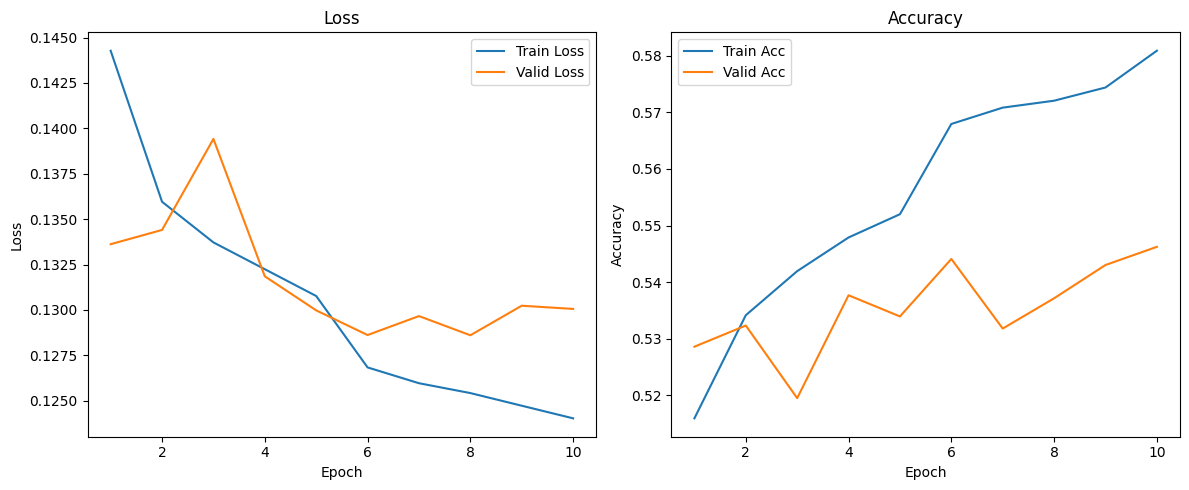

In [18]:
import os
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
 

# 随机种子相关功能
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def save_seed(seed, path='seed.txt'):
    with open(path, 'w') as f:
        f.write(str(seed))

def load_seed(path='seed.txt'):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return int(f.read().strip())
    else:
        raise FileNotFoundError(f"Seed file not found at {path}")

# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 设置随机种子
seed = 55
set_seed(seed)
save_seed(seed, path='seed55.txt')
print(f"Random seed set to: {seed}")

# 初始化模型并移动到 GPU
model = TextAudioCrossAttentionClassifier(
    text_dim=768,
    audio_dim=1024,
    hidden_dim=256,
    num_heads=8,
    dropout_rate=0.01,
    num_classes=7
).to(device)

# 定义损失函数和优化器
classification_criterion = nn.CrossEntropyLoss()
contrastive_weight = 0  # 设置对比损失的权重（可调整）
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

best_valid_accuracy = 0.0
best_model_path = 'acc7-textaudio-ablation-best_model5.pth'

# 训练与验证循环
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_samples = 0, 0, 0

    for text_features, audio_features, labels in train_loader:
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # 前向传播
        outputs, contrastive_loss = model(text_features, audio_features)

        # 总损失
        classification_loss = classification_criterion(outputs, labels)
        total_loss = classification_loss + contrastive_weight * contrastive_loss

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        predicted = torch.argmax(outputs, dim=1)
        train_correct += (predicted == labels).sum().item()
        train_samples += labels.size(0)

    train_losses.append(train_loss / train_samples)
    train_accuracies.append(train_correct / train_samples)
    scheduler.step()

    # 验证模式
    model.eval()
    valid_loss, valid_correct, valid_samples = 0, 0, 0
    with torch.no_grad():
        for  text_features, audio_features, labels in valid_loader:
            text_features = text_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs, contrastive_loss = model(text_features, audio_features)

            classification_loss = classification_criterion(outputs, labels)
            total_loss = classification_loss + contrastive_weight * contrastive_loss

            valid_loss += total_loss.item()
            predicted = torch.argmax(outputs, dim=1)
            valid_correct += (predicted == labels).sum().item()
            valid_samples += labels.size(0)

    valid_losses.append(valid_loss / valid_samples)
    valid_accuracies.append(valid_correct / valid_samples)

    # 保存最优模型
    if valid_accuracies[-1] > best_valid_accuracy:
        best_valid_accuracy = valid_accuracies[-1]
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'random_seed': seed
        }, best_model_path)
        print(f"New best model saved with accuracy: {best_valid_accuracy:.4f}")

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Valid Loss = {valid_losses[-1]:.4f}, Valid Acc = {valid_accuracies[-1]:.4f}")

# 可视化训练与验证结果
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import pearsonr
import numpy as np
import torch

# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型（必须和训练时完全一致）
model = TextAudioCrossAttentionClassifier(
    text_dim=768,
    audio_dim=1024,
    hidden_dim=256,
    num_heads=8,
    dropout_rate=0.01,
    num_classes=7
).to(device)

# 加载最优权重
best_model_path = 'acc7-textaudio-ablation-best_model5.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 收集真实标签和预测标签
true_labels = []
predicted_labels = []

# 推理
with torch.no_grad():
    for text_features, audio_features, labels in test_loader:
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        labels = labels.to(device)

        outputs, _ = model(text_features, audio_features)
        predicted = torch.argmax(outputs, dim=1).cpu().numpy()
        predicted_labels.extend(predicted)
        true_labels.extend(labels.cpu().numpy())

# 转换为 numpy 数组
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# 计算分类指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# 混淆矩阵与 UA、WA
cm = confusion_matrix(true_labels, predicted_labels)
with np.errstate(divide='ignore', invalid='ignore'):
    per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    per_class_accuracy = np.nan_to_num(per_class_accuracy)
    ua = np.mean(per_class_accuracy)  # Unweighted Average Accuracy
wa = accuracy  # Weighted accuracy = overall accuracy

# MAE 与 Pearson
mae = np.mean(np.abs(true_labels - predicted_labels))
corr, _ = pearsonr(true_labels, predicted_labels)

# 打印结果
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Unweighted Average (UA): {ua:.4f}")
print(f"Weighted Average (WA): {wa:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Correlation (Corr): {corr:.4f}")

# 打印详细分类报告
target_names = [f"Class {i}" for i in range(7)]
print("\nDetailed classification report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))


Accuracy: 0.5548
Precision: 0.5045
Recall: 0.3817
F1 Score: 0.4152
Unweighted Average (UA): 0.3817
Weighted Average (WA): 0.5548
Mean Absolute Error (MAE): 0.5126
Correlation (Corr): 0.7088

Detailed classification report:
              precision    recall  f1-score   support

     Class 0       0.56      0.14      0.23        70
     Class 1       0.56      0.42      0.48       399
     Class 2       0.45      0.37      0.41       554
     Class 3       0.60      0.77      0.68      1926
     Class 4       0.51      0.46      0.48      1229
     Class 5       0.51      0.34      0.40       440
     Class 6       0.35      0.17      0.23        41

    accuracy                           0.55      4659
   macro avg       0.50      0.38      0.42      4659
weighted avg       0.54      0.55      0.54      4659



: 